# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. Challenges might be sampling convergence due to high energy barriers or entropy differences. 


To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Free Energy as:

$F_i = V_i - T_i  S_i = -\beta ln(Z_i) $



Or we can use the statistical approach:

$F_i(t) = -\frac{1}{\beta}  ln(\langle e^{-\beta H_i(t)}\rangle_i)$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta F_{ij} = F_j - F_i = -\beta ln(\frac{Z_i}{Z_j})$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 

In [1]:
import pymbar

C:\Users\benja\anaconda3\envs\testBar\lib\site-packages\scipy\__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


In [2]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

from ensembler.conditions.box_conditions import periodicBoundaryCondition


import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [3]:
simulation_steps_total_per_approach = 10000
space_range = [-10, 10]
rand=0.1


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us. These two harmonic oscillators could for example describe the difference of types of bonds.



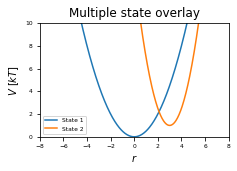

In [22]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 = 3 #2 #0.5
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([h1,h2])
#fig.tight_layout()
#fig.savefig("2state_systems.png")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ F_i = V_i - T_i  S_i $

For a harmonic Oscillator the entropy term can be formulated as:

$F_i = V_i - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$



The final free energy difference is:

$\Delta F_{ij} = F_j - F_i$ 


In [15]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  1.27465307217


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated seperatley. Afterwards, the trajectories will be evaluated  with the opposite state and afterwards the free energy will be evaluated.

### Sampling
Now we build first the two systems and run the simulations.


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001DF75E2F940>]}


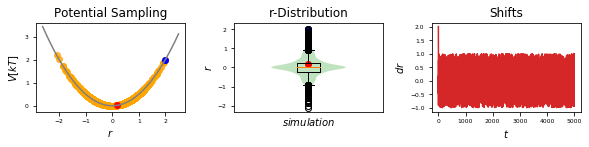

In [23]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
integrator2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, integrator=integrator, position=2)
system2 = system(potential=h2, integrator=integrator2, position=4)

##Simulate:
system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1)


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001DF76F514E0>]}


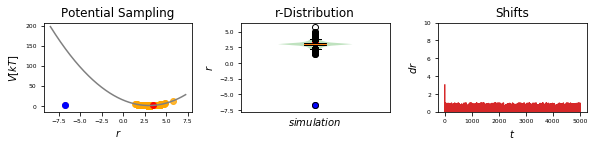

In [25]:


system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()

#visualize
_ = static_sim_plots(system2)
plt.ylim([0,10])
pass

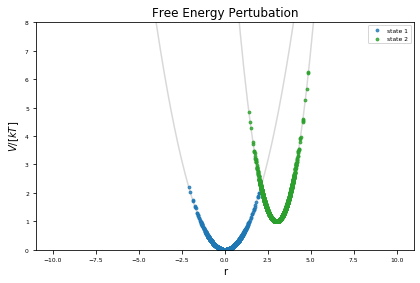

In [26]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="state 1",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="state 2",s=8)
ax[0].set_ylim([0,8])

ax[0].set_xlabel("r")
ax[0].set_xlabel("r")

ax[0].set_ylabel("$V/[kT]$")
#ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Free Energy Pertubation")
#ax[0].set_title("State 2")

fig.savefig("freeEnergyPertubation.png")

### Analysis
#### Zwanzig Equation

In [27]:
V1=state1_traj.totEnergy[equilibration_steps:]
#V2=state2_traj.totEnergy[equilibration_steps:]
V2=h2.ene(state1_traj.position[equilibration_steps:])


zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  1.27465307217
Zwanzig Result:  7.175639469818329

Difference: 5.90098639765


#### Bennet Acceptance Ratio (BAR)

In [28]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

w_fw = np.array(V21 - V11, dtype=np.float)
w_rv = np.array(V12 - V22, dtype=np.float)

(DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
(DeltaF, dDeltaF)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)



Expected Result:  1.27465307217
pymbar - BAR Result:  3.17630415698

Difference: 1.90165108481


In [29]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

state_1 =np.concatenate([V11, V12])
state_2 =np.concatenate([V21, V22])
mbar = pymbar.mbar.MBAR(u_kn=[state_1, state_2], N_k=[len(state_1)/2, len(state_2)/2])
df_mbars, df, _ = mbar.getFreeEnergyDifferences()
print(df_mbars)
df_mbar = np.mean(df_mbars)

overlap, _, _ = mbar.computeOverlap()
print("overlap: ", overlap)


print()
print("Expected Result: ", dG_expected)
print("pymbar - BAR Result: ", DeltaF)
print()
print("Difference:", DeltaF - dG_expected)


[[ 0.          3.17630416]
 [-3.17630416  0.        ]]
overlap:  0.0148777002646

Expected Result:  1.27465307217
pymbar - BAR Result:  3.17630415698

Difference: 1.90165108481


In [30]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iterate: 	convergence raidus: 1e-05
Iteration: 0	dF: 2.666478907952599164716074826 	convergence 2.666478907952599164716074826
Iteration: 1	dF: 2.155544303213899900505283206 	convergence 0.510934604738699264210791620
Iteration: 2	dF: 2.226049289195450691625698247 	convergence 0.070504985981550791120415041
Iteration: 3	dF: 2.215863662702425093292323930 	convergence 0.010185626493025598333374317
Iteration: 4	dF: 2.217324734725451048714325005 	convergence 0.001461072023025955422001075
Iteration: 5	dF: 2.217114939856387373202084347 	convergence 0.000209794869063675512240658
Iteration: 6	dF: 2.217145059854951707584729868 	convergence 0.000030119998564334382645521
Iteration: 7	dF: 2.217140735472496502924772379 	convergence 0.000004324382455204659957489

Final Iterations:  7  Result:  2.217140735472496502924772379

Expected Result:  1.27465307217
BAR Result:  2.2171407354724963

Difference: 0.942487663305


# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

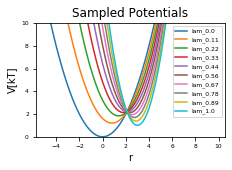

In [31]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [32]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
perturbed_system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lam(lam)
    perturbed_system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

#### Exponential Formula

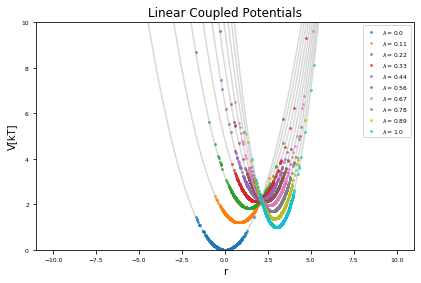

In [33]:
from ensembler import visualisation

#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [0, 10]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))
for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lam(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    
    axes[0].plot(positions,ene, c="grey", zorder=-10,alpha=0.3)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

#axes[1].violinplot(logExp, positions=all_lams, showextrema=False, widths=[0.1 for x in range(len(all_lams))])
#axes[1].boxplot(logExp,  positions=np.round(all_lams, 2), widths=[0.1 for x in range(len(all_lams))])

axes[0].legend()
axes[0].set_ylim(y_range)
axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Linear Coupled Potentials")

#axes[1].set_xlim([-0.2,1.2])
#axes[1].set_ylim([-1,30])

fig.savefig("linear_coupled.png")

### FEP with multiple lambda windows:

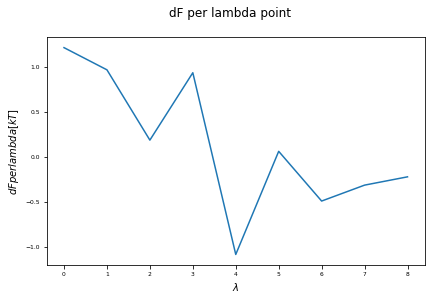


Expected Result:  1.27465307217
trapez Rule Result:  1.26102617222

Difference: -0.0136268999492


(-0.013626899949216176,)

In [34]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.totPotEnergy
    Vj_fw = trajJ.totPotEnergy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

A_fw = np.sum(dA_i_fw)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", A_fw)
print()
print("Difference:", A_fw - dG_expected)


A_fw-dG_expected,

#### Thermodynamic Integration

Text(0.5, 0.98, 'dH/d$\\lambda$ for each Lambda point')

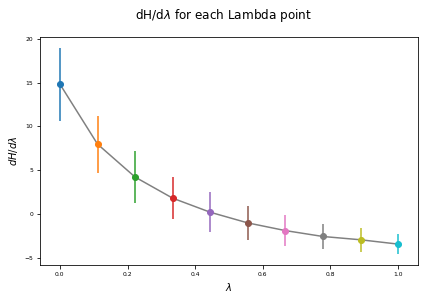

In [35]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dH/d$\lambda$ for each Lambda point")


In [36]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [37]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  1.27465307217
trapez Rule Result:  1.25396051077 +- 2.23463067825

Difference: -0.0206925614007


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

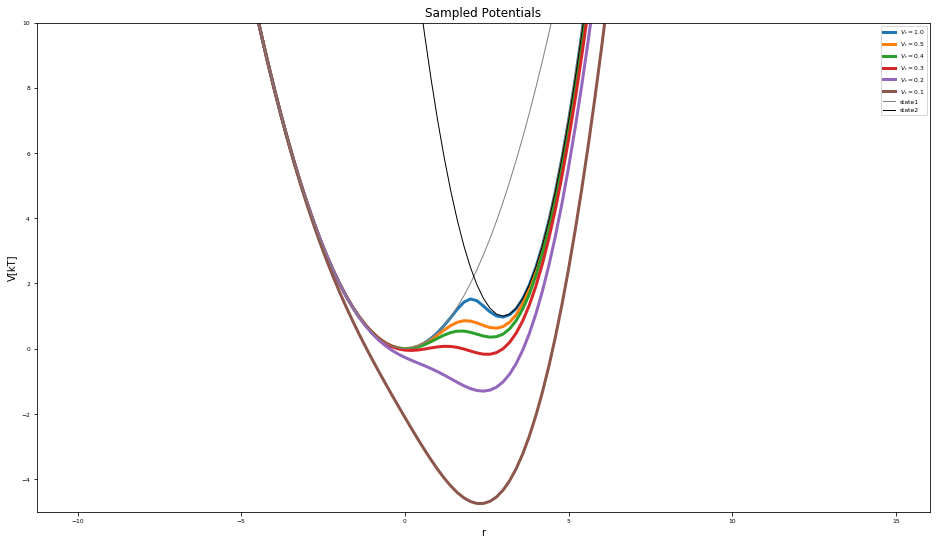

In [68]:
#Build Potential
s=100
Eoff = [0, 0]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s, Eoff_i=Eoff)
s_values = np.array([ 1,0.5, 0.4, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,15, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
#plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [69]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_eds, integrator=integrator, eds_Eoff=Eoff)
eds_simulation_trajs = []

for ind,s in enumerate(s_values): #s_values
    print(ind, "\t", s)
    eds_system.set_s(s)
    eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state1_traj = eds_system.getTrajectory()
    eds_simulation_trajs.append(state1_traj)
    time.sleep(2)

0 	 1.0



1 	 0.5



2 	 0.4



3 	 0.3



4 	 0.2



5 	 0.1


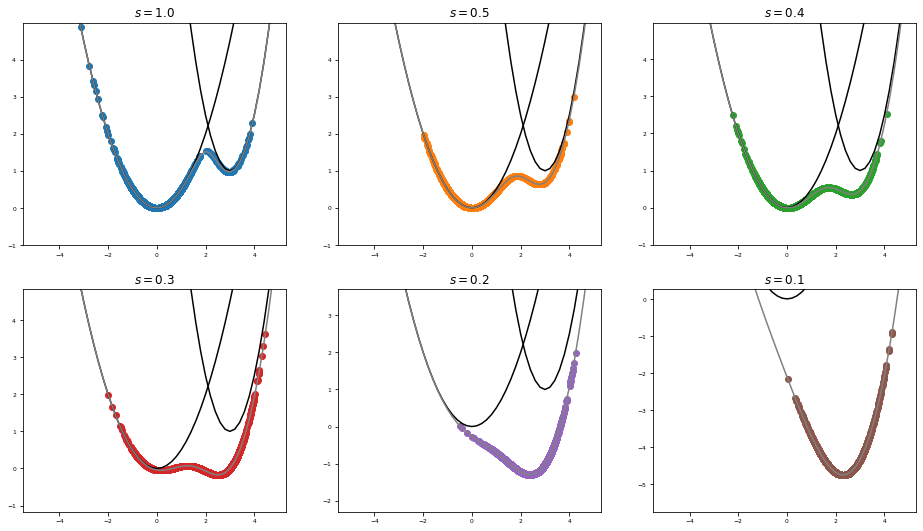

In [70]:
#Visualisation
seperateeach=3
rel_max = 5
positions = np.arange(-5,5, 0.2)

nTrajs = len(eds_simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(eds_simulation_trajs):
    V_eds.s_i = traj.s[1]
    ene =  V_eds.ene(positions)
    axes[ind].plot(positions, h1.ene(positions), c="black" )
    axes[ind].plot(positions, h2.ene(positions), c="black" )
    axes[ind].plot(positions, ene, c="grey", )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="C"+str(ind%10))
    axes[ind].set_ylim([np.min(ene)-1,np.min(ene)+rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


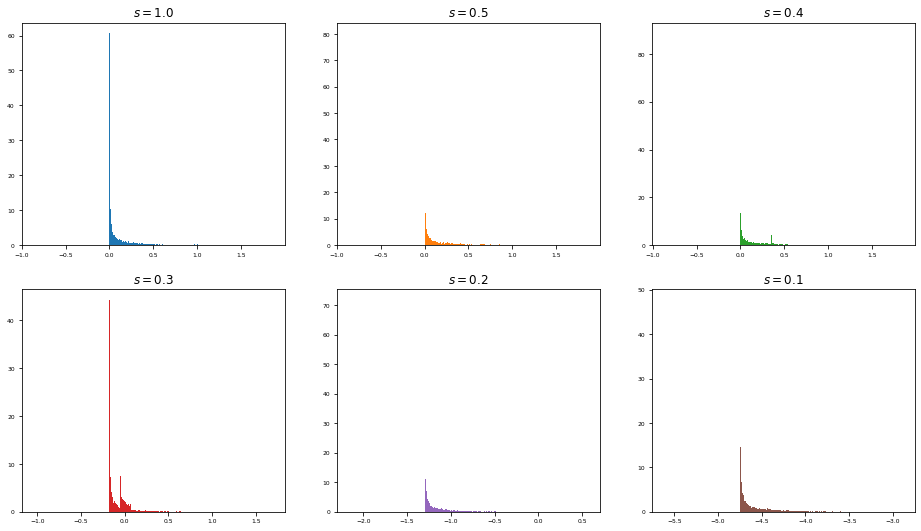

In [71]:
#Visualisation
seperateeach=3
rel_max = 2
nTrajs = len(eds_simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(eds_simulation_trajs):
    axes[ind].hist(traj.totPotEnergy[equilibration_steps:], color="C"+str(ind%10), density=True, bins=1000)
    min_ene = np.min(traj.totPotEnergy[equilibration_steps:])
    axes[ind].set_xlim([min_ene-1, min_ene+rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


In [112]:
from ensembler import visualisation
    
traj = eds_simulation_trajs[4].iloc[equilibration_steps:]
#print(traj)
positions = np.linspace(-10,10, 100)
h1_ene = h1.ene(positions)
h2_ene = h2.ene(positions)
V_eds.s = traj.s[equilibration_steps]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.totPotEnergy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, h1_ene, c="grey", zorder=-10,alpha=0.3)
ax[0].plot(positions, h2_ene, c="black", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene, c="C0", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="Enveloping State",s=8)
#ax[0].scatter(traj_pos[-1], traj_ene[-1], c="red",zorder=100, label="End",s=8)
#ax[0].scatter(traj_pos[equilibration_steps], traj_ene[equilibration_steps], c="orange", zorder=100, label="Start",s=8)

ax[0].set_ylim([0,8])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Enveloping Distribution Sampling")

fig.savefig("EDS_sampling.png")

TypeError: <lambda>() takes 1 positional argument but 2 were given

### FEP-EDS_Evaluation

In [76]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(eds_simulation_trajs):
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    
    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    Vik = zwanz.calculate(Vi=V1, Vj=Vr)
    Vjk = zwanz.calculate(Vi=V2, Vj=Vr)
    Vijk = Vjk-Vik
    
    print("SIMULATION ", ind)
    print("s: ", traj.s[2])
    print("dF =  ", dFRew_zwanz)
    print("DF1: ", Vik)
    print("DF2: ", Vjk)
    print("DF2: ", Vijk)
    print("deviation: ", Vijk-dG_expected)
    dFresults.append(Vijk)

print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


SIMULATION  0
s:  1.0
dF =   42.80712478982243
DF1:  -0.034275275851717565
DF2:  -14.546456910442279
DF2:  -14.512181634590561
deviation:  -15.7868347068
SIMULATION  1
s:  0.5
dF =   27.462567898329215
DF1:  -0.0939497096247942
DF2:  -14.271100856057284
DF2:  -14.17715114643249
deviation:  -15.4518042186
SIMULATION  2
s:  0.4
dF =   29.481666673631043
DF1:  -0.22959955426552922
DF2:  -13.498908077359605
DF2:  -13.269308523094075
deviation:  -14.5439615953
SIMULATION  3
s:  0.3
dF =   23.87334186395458
DF1:  -2.225517727859359
DF2:  -5.47007090131897
DF2:  -3.2445531734596114
deviation:  -4.51920624563
SIMULATION  4
s:  0.2
dF =   5.9164379134103315
DF1:  -4.028670980282155
DF2:  -3.1527343375115033
DF2:  0.8759366427706516
deviation:  -0.398716429396
SIMULATION  5
s:  0.1
dF =   0.6633251047735955
DF1:  -7.287885774027782
DF2:  -6.693439652307858
DF2:  0.5944461217199235
deviation:  -0.680206950447

	Expected Result:  1.27465307217
s		dF		diff
1.0		-14.51218		-15.78683
0.5		-14.17715		

### BAR-EDS_Evaluation

In [79]:
import pymbar

dF_BAR_results = []
s_vals = []

for ind,traj in enumerate(eds_simulation_trajs):
    s_vals.append(traj.s[1])

    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)
    
    print(V1)
    w_fw = np.array(V1 - Vr, dtype=np.float)
    w_rv = np.array(V2 - Vr, dtype=np.float)

    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=w_rv, DeltaF=0, method='bisection', verbose=False)
    dF_BAR_results.append(DeltaF)


print(dF_BAR_results)        
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dF_BAR_results, dF_BAR_results - dG_expected)])))
print("\n\n\n")

[3.3596012542728258e-05 0.024289738694232784 0.012389188897918646 ...,
 0.0043885538270302888 0.22175396988138646 0.068169211174443772]
[0.008581823485198618 0.0052059324752378308 1.3746999010616326e-06 ...,
 8.5490498259062044e-05 0.016819378321331676 1.0381422978621427e-05]
[0.19106567944328237 0.0016479983629502832 0.00088738675166044471 ...,
 0.015765030071329567 0.054379051063386599 0.51876303785727518]
[2.8830921016953659 2.3663231448647504 2.9930923338521889 ...,
 2.8967087808596319 3.2508858121891913 3.2711798680448925]
[2.6790847869188164 2.8781771643098555 2.8624277444347785 ...,
 2.3832687684785401 3.164281816892371 4.5069550665044824]
[2.5509188481701592 1.1228448961617101 2.7016581810794116 ...,
 2.4335036783961388 1.7961343647928014 0.91061077237652033]
[-3.9590705013038869, -3.4299635192089846, -2.698859391469278, -0.37108898771776017, 0.35757008732521489, 0.16548606921116277]

	Expected Result:  1.27465307217
s		dF		diff
1.0		-3.95907		-5.23372
0.5		-3.42996		-4.70462
0

# Hybrid Methods - $\lambda-EDS $

In [ ]:
#Build Potential
s=1
V_hleds = pot.hybridCoupledPotentials(Va=h1, Vb=h2, s=1, lam=0.5)

#Build Potential
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[h1,h2] , s=s)
s_values = np.array([1, 0.5, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [ ]:
#simulate
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
hleds_system = edsSystem(potential=V_hleds, integrator=integrator, eds_Eoff=Eoff)
hleds_simulation_trajs = []

for s in s_values:
    hleds_system.set_s(s)
    #print(hleds_system.potential)
    hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
    state_traj = hleds_system.getTrajectory()
    hleds_simulation_trajs.append(state_traj)


In [ ]:
#Visualisation
seperateeach=3
rel_max = 5

nTrajs = len(hleds_simulation_trajs)
nrows = (nTrajs//seperateeach)+1 if(nTrajs%seperateeach >0) else(nTrajs//seperateeach)
ncols = seperateeach if(nTrajs>seperateeach) else nTrajs

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[16,9])
axes= np.concatenate(axes)
for ind, traj in enumerate(hleds_simulation_trajs):
    V_hleds.s_i = traj.s[1]
    ene =  V_hleds.ene(positions)
    axes[ind].plot(positions, h1.ene(positions), c="black" )
    axes[ind].plot(positions, h2.ene(positions), c="black" )

    axes[ind].plot(positions, ene, c="grey" )
    axes[ind].scatter(list(traj.position[equilibration_steps:]), traj.totPotEnergy[equilibration_steps:], c="C"+str(ind))
    axes[ind].set_ylim([0, rel_max])
    axes[ind].set_title("$s = "+str(round(traj.s[1],3))+"$")


In [ ]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)

dFresults = []
s_vals = []
for ind,traj in enumerate(hleds_simulation_trajs):
    #print("SIMULATION ", ind)
    s_vals.append(traj.s[1])
    traj_positions = traj.position[equilibration_steps:]
    Vr = traj.totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_hleds_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    dFresults.append(dFRew_hleds_zwanz)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


#### Enhanced Sampling with system Coupling

#### Conveyor Belt TI

In [ ]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system

#CHEKC HERE H1 and H2 die
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

lam_system = perturbed_system.perturbedSystem(potential=V_perturbed , integrator=integrator)
conveyorBelt=cvb.ConveyorBelt(0.0, numsys, system=lam_system, build=False)


In [ ]:
conveyorBelt.simulate(steps//numsys)
cvb_trajs = conveyorBelt.get_trajectories()


In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=style.figsize_doubleColumn, sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

In [ ]:
nbins=50
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

frequencies, lam_bins = np.histogram(list(sorted(np.unique(mega_traj.lam))), bins=nbins, density=True)
plt.figure(figsize=[16,9])
plt.bar(x=lam_bins[:-1], height=frequencies, width=1/nbins)

In [ ]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.totPotEnergy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.png")

In [ ]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )
means_cvb

In [ ]:
plt.plot(means_cvb)

In [ ]:
dF_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_err = integrate.trapz(x=means_cvb, y=std_cvb)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)


# RE-EDS

[0, 0]
DO trials:  500 steps:  20
0 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF0BB54FD0>
[1.0, 1.0]
[0, 0]
1 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF0BB63DA0>
[0.77426368268112711, 0.77426368268112711]
[0, 0]
2 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF0BC10198>
[0.59948425031894104, 0.59948425031894104]
[0, 0]
3 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF11811DD8>
[0.46415888336127792, 0.46415888336127792]
[0, 0]
4 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF11810B38>
[0.35938136638046275, 0.35938136638046275]
[0, 0]
5 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF117AC748>
[0.27825594022071243, 0.27825594022071243]
[0, 0]
6 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF117994A8>
[0.21544346900318839, 0.21544346900318839]
[0, 0]
7 	 <ensembler.system.eds_system.edsSystem object at 0x000001DF117BA208>
[0.1668100537200059, 0.1668100537200059]
[0, 0]
8 	 <ensembler.s

Text(0.5, 1.0, 'Sampled Potentials')

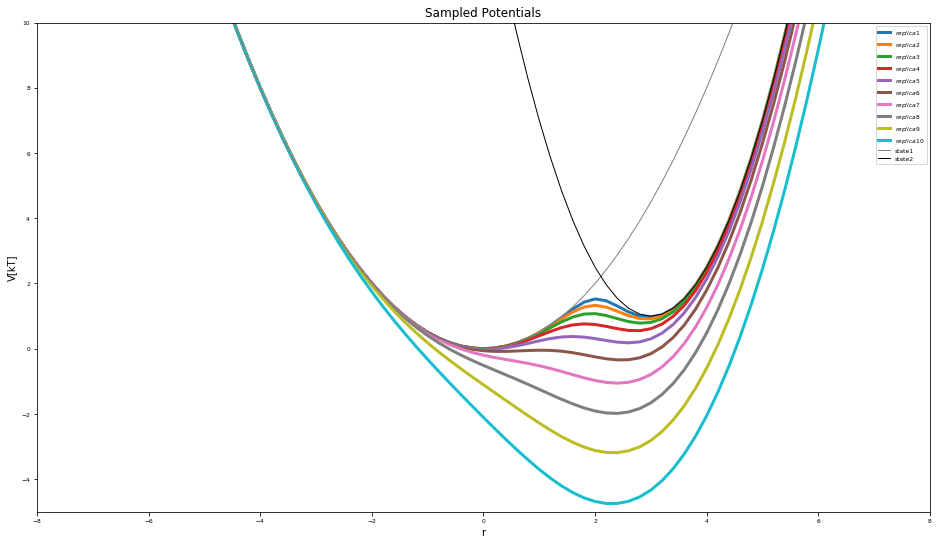

In [113]:
#potential
Eoff = [0,0]
V_eds = pot.envelopedPotential(V_is=[h1,h2])

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=10)
trials=500
steps_between_trials=simulation_steps_total_per_approach//(trials) #len(s_values)*

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)
[replica.s for repID, replica in ensemble.replicas.items()]

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    print(ind, "\t", replica)
    print(replica.potential.s)
    print(replica.potential.Eoff)

    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


In [114]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.get_trajectories()


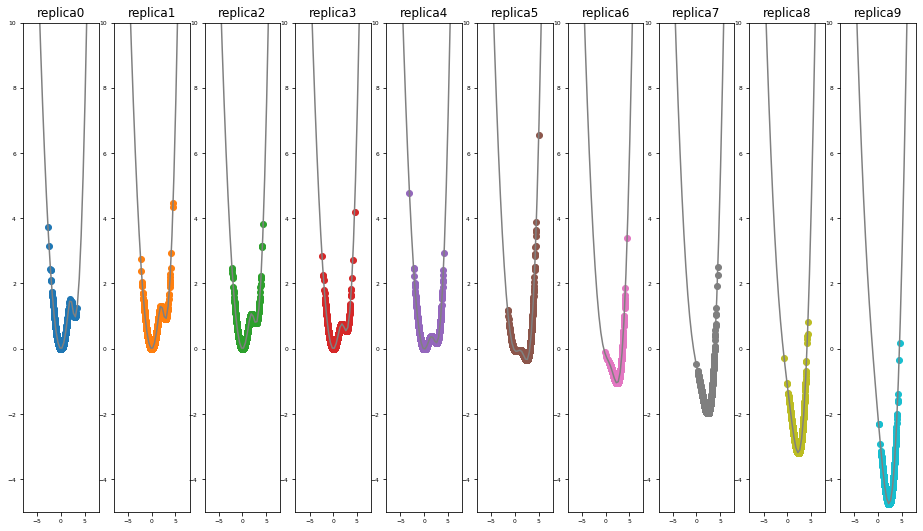

In [115]:

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(reeds_trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(reeds_trajs[traj].totEnergy[eqil:])
    ax.scatter(reeds_trajs[traj].position[eqil:], reeds_trajs[traj].totEnergy[eqil:], c="C"+str(traj))
    ax.set_ylim([min_e-1,min_e+5])
    ax.set_xlim([-4,8])
    ax.set_ylim([-5,10])
    ax.set_xlim([-8,8])
    ax.set_title("replica"+str(traj))


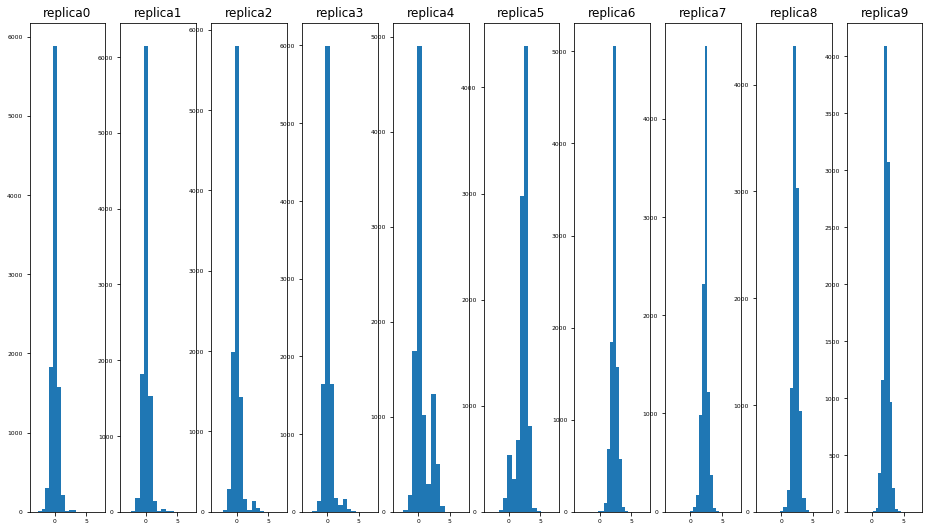

In [116]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


TypeError: only integer arrays with one element can be converted to an index

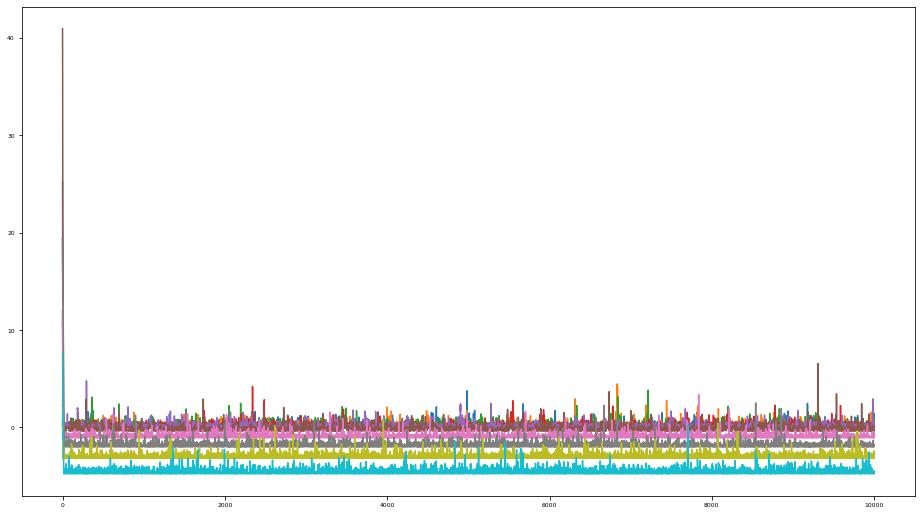

In [121]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

In [ ]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [ ]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
equilibration_steps=10
#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    
    #dFresults.append(dFRew_zwanz)
    
        
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    Vik = zwanz.calculate(Vi=V1, Vj=Vr)
    Vjk = zwanz.calculate(Vi=V2, Vj=Vr)
    Vijk = Vjk-Vik
    
    print("Replica ", ind)
    print("s: ",reeds_trajs[key].s[1])
    print("dF_rew =  ", dFRew_zwanz)
    print("DF1: ", Vik)
    print("DF2: ", Vjk)
    print("DFF: ", Vijk)
    print("deviation: ", Vijk-dG_expected)
    dFresults.append(Vijk)
    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")


#### 

In [122]:
rew_zwanz = threeStateZwanzigReweighting(kT=True)
equilibration_steps=10
#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].totEnergy[equilibration_steps:]
    V1 = h1.ene(traj_positions)
    V2 = h2.ene(traj_positions)

    w_fw = np.array(V1 - Vr, dtype=np.float)
    w_rv = np.array(V2 - Vr, dtype=np.float)

    (DeltaF, dDeltaF)=pymbar.BAR(w_F=w_fw, w_R=-w_rv, DeltaF=0, method='bisection', verbose=False)
    dFresults.append(DeltaF)

    
print()
print("\tExpected Result: ", dG_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dG_expected)])))
print("\n\n\n")



	Expected Result:  1.27465307217
s		dF		diff
1.0		4.406		3.13134
0.77426		4.24457		2.96991
0.59948		3.85609		2.58144
0.46416		3.7083		2.43365
0.35938		2.77692		1.50227
0.27826		2.64704		1.37239
0.21544		3.30848		2.03383
0.16681		4.22102		2.94636
0.12915		5.41565		4.141
0.1		6.96755		5.6929




